In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
from PIL import Image

## Load Dataset

In [2]:
train_image_dir = Path(r"L:\Datasets\archive\Snake Images\train")

In [3]:
tr_filepaths = list(train_image_dir.glob(r'**/*.jpg'))
len(tr_filepaths)

1757

In [4]:
test_image_dir = Path(r"L:\Datasets\archive\Snake Images\test")

In [5]:
ts_filepaths = list(test_image_dir.glob(r'**/*.jpg'))
len(ts_filepaths)

267

In [6]:
tr_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], tr_filepaths))
ts_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], ts_filepaths))
print(len(tr_labels))
print(len(ts_labels))

1757
267


## Creating a Dataframe

In [7]:
tr_filepaths = pd.Series(tr_filepaths, name='Filepath').astype(str)
ts_filepaths = pd.Series(ts_filepaths, name='Filepath').astype(str)

In [8]:
tr_labels = pd.Series(tr_labels, name='Label')
ts_labels = pd.Series(ts_labels, name='Label')

In [9]:
train_df = pd.concat([tr_filepaths, tr_labels], axis=1)
test_df = pd.concat([ts_filepaths, ts_labels], axis=1)

In [10]:
print(test_df.head())
print(train_df.head())

                                            Filepath         Label
0  L:\Datasets\archive\Snake Images\test\Non Veno...  Non Venomous
1  L:\Datasets\archive\Snake Images\test\Non Veno...  Non Venomous
2  L:\Datasets\archive\Snake Images\test\Non Veno...  Non Venomous
3  L:\Datasets\archive\Snake Images\test\Non Veno...  Non Venomous
4  L:\Datasets\archive\Snake Images\test\Non Veno...  Non Venomous
                                            Filepath         Label
0  L:\Datasets\archive\Snake Images\train\Non Ven...  Non Venomous
1  L:\Datasets\archive\Snake Images\train\Non Ven...  Non Venomous
2  L:\Datasets\archive\Snake Images\train\Non Ven...  Non Venomous
3  L:\Datasets\archive\Snake Images\train\Non Ven...  Non Venomous
4  L:\Datasets\archive\Snake Images\train\Non Ven...  Non Venomous


In [11]:
test_df = test_df.sample(frac=1).reset_index(drop = True)
train_df = train_df.sample(frac=1).reset_index(drop = True)

In [12]:
train_df.head(10)

,Filepath,Label
0,L:\Datasets\archive\Snake Images\train\Non Ven...,Non Venomous
1,L:\Datasets\archive\Snake Images\train\Non Ven...,Non Venomous
2,L:\Datasets\archive\Snake Images\train\Non Ven...,Non Venomous
3,L:\Datasets\archive\Snake Images\train\Venomou...,Venomous
4,L:\Datasets\archive\Snake Images\train\Venomou...,Venomous
5,L:\Datasets\archive\Snake Images\train\Non Ven...,Non Venomous
6,L:\Datasets\archive\Snake Images\train\Venomou...,Venomous
7,L:\Datasets\archive\Snake Images\train\Non Ven...,Non Venomous
8,L:\Datasets\archive\Snake Images\train\Venomou...,Venomous
9,L:\Datasets\archive\Snake Images\train\Non Ven...,Non Venomous


In [13]:
test_df.head(10)

,Filepath,Label
0,L:\Datasets\archive\Snake Images\test\Non Veno...,Non Venomous
1,L:\Datasets\archive\Snake Images\test\Venomous...,Venomous
2,L:\Datasets\archive\Snake Images\test\Venomous...,Venomous
3,L:\Datasets\archive\Snake Images\test\Non Veno...,Non Venomous
4,L:\Datasets\archive\Snake Images\test\Non Veno...,Non Venomous
5,L:\Datasets\archive\Snake Images\test\Venomous...,Venomous
6,L:\Datasets\archive\Snake Images\test\Venomous...,Venomous
7,L:\Datasets\archive\Snake Images\test\Venomous...,Venomous
8,L:\Datasets\archive\Snake Images\test\Non Veno...,Non Venomous
9,L:\Datasets\archive\Snake Images\test\Non Veno...,Non Venomous


## Data Visualization

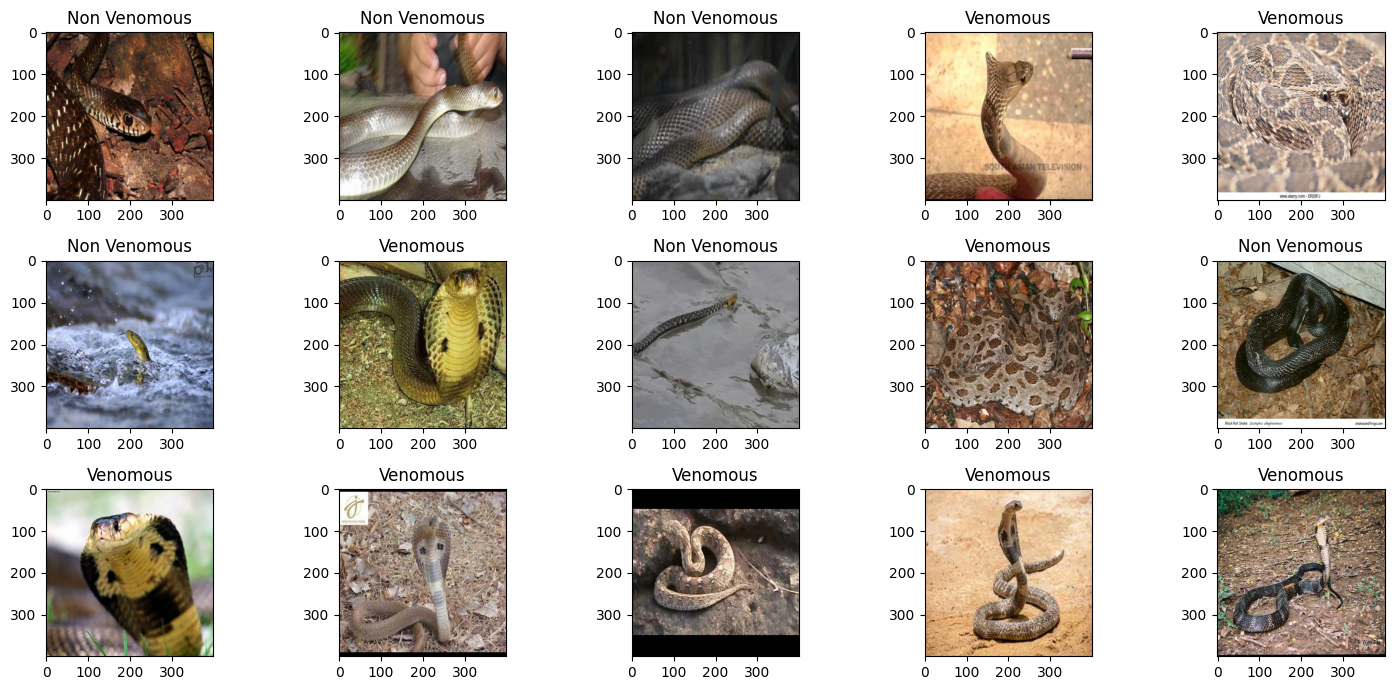

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

In [15]:
import tensorflow as tf 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

## Image Augumentation and Validation 

In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

Found 1406 validated image filenames belonging to 2 classes.
Found 351 validated image filenames belonging to 2 classes.
Found 267 validated image filenames belonging to 2 classes.


## Creating Model

In [19]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=2)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
     
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [20]:
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]


In [21]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [22]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

In [23]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
)

Epoch 1/25
176/176 [==============================] - 166s 845ms/step - loss: 0.6291 - accuracy: 0.6479 - auc: 0.7066 - val_loss: 0.7665 - val_accuracy: 0.5726 - val_auc: 0.5528
Epoch 2/25
176/176 [==============================] - 65s 368ms/step - loss: 0.5595 - accuracy: 0.7304 - auc: 0.7764 - val_loss: 0.7211 - val_accuracy: 0.5755 - val_auc: 0.5896
Epoch 3/25
176/176 [==============================] - 29s 162ms/step - loss: 0.4677 - accuracy: 0.7930 - auc: 0.8523 - val_loss: 0.9939 - val_accuracy: 0.5755 - val_auc: 0.5452
Epoch 4/25
176/176 [==============================] - 29s 162ms/step - loss: 0.4208 - accuracy: 0.8193 - auc: 0.8805 - val_loss: 0.9315 - val_accuracy: 0.5755 - val_auc: 0.6036
Epoch 5/25
176/176 [==============================] - 29s 163ms/step - loss: 0.3912 - accuracy: 0.8286 - auc: 0.8973 - val_loss: 0.7004 - val_accuracy: 0.5527 - val_auc: 0.5867
Epoch 6/25
176/176 [==============================] - 29s 163ms/step - loss: 0.3159 - accuracy: 0.8698 - auc: 0.93

## Testing Accuracy

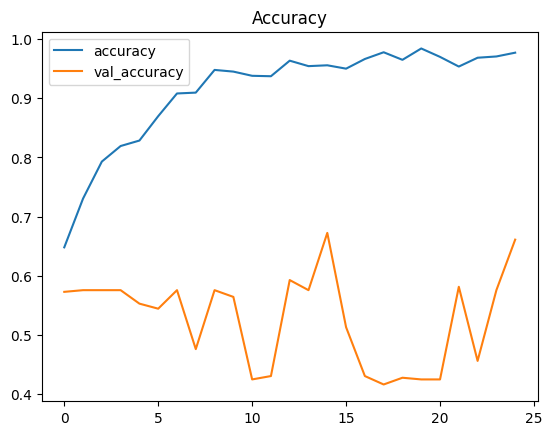

In [24]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [25]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.77673
Test Accuracy: 72.28%


In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

34/34 [==============================] - 3s 37ms/step
The first 5 predictions: ['Non Venomous', 'Non Venomous', 'Venomous', 'Non Venomous', 'Non Venomous']


In [27]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

Non Venomous       0.72      0.70      0.71       128
    Venomous       0.73      0.75      0.74       139

    accuracy                           0.72       267
   macro avg       0.72      0.72      0.72       267
weighted avg       0.72      0.72      0.72       267



## Confusion Matrix

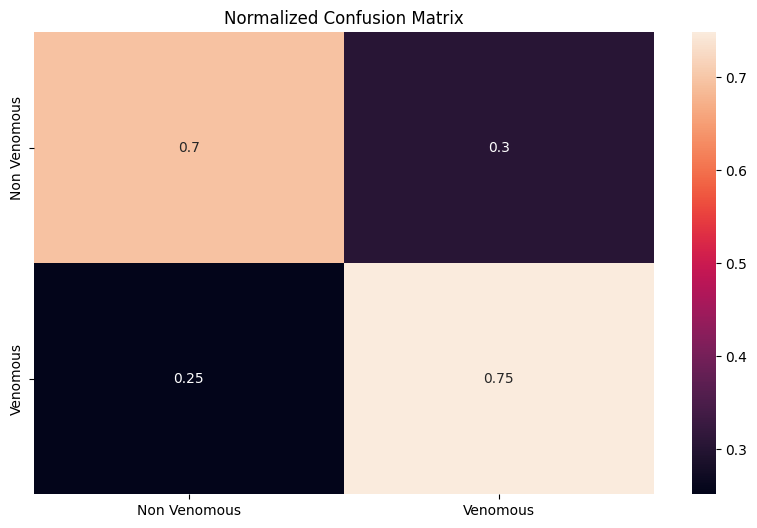

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

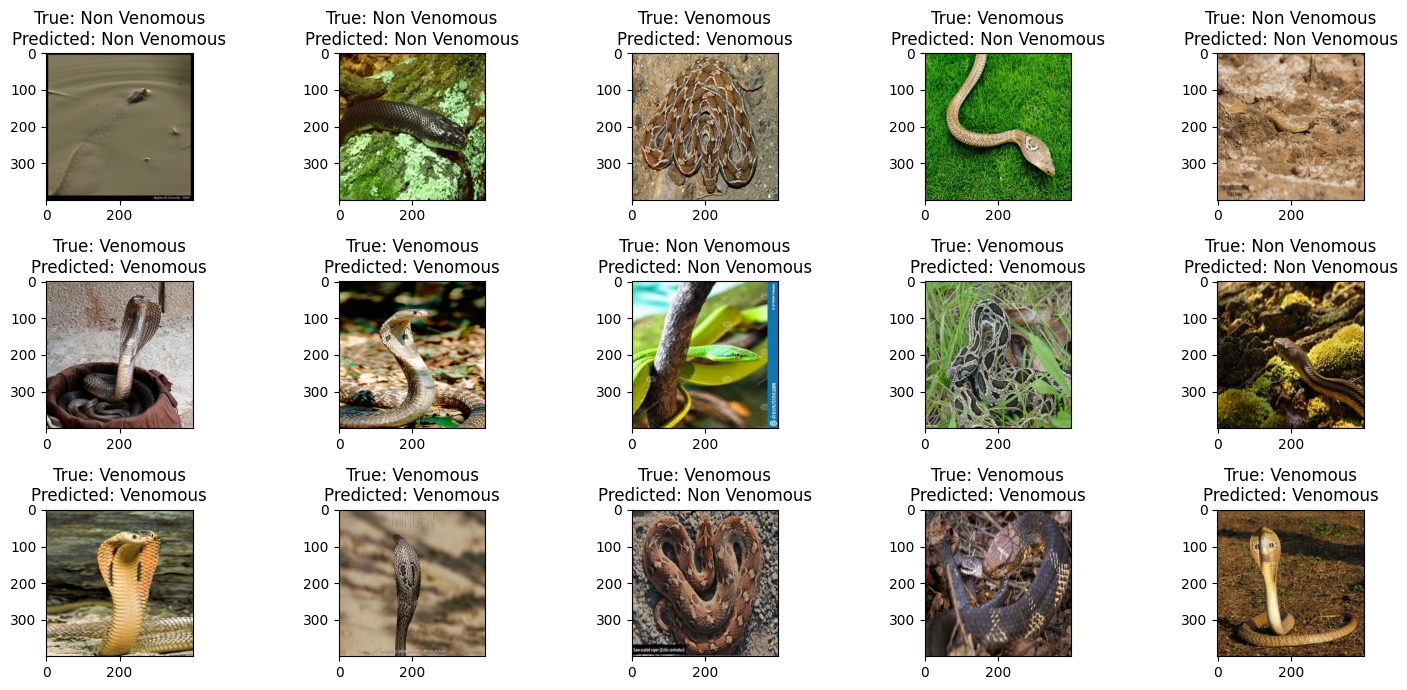

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## The model gives a test accuracy of 71 percentage, the confusion matrix cleary shows that the model still classfies a significant amount of venomous snakes as non venomous.
Hence it should not be used as a full fleged model yet.

In [1]:
model.save("Snake_prediction_model.h5")

NameError: name 'model' is not defined

# Second Model


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 model (excluding top layers)
base_model = MobileNetV2(classes=2, include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
model = Sequential()

# Add the MobileNetV2 base model to the sequential model
model.add(base_model)

# Add additional layers on top of MobileNetV2
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Ensure appropriate padding
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Ensure appropriate padding
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Ensure appropriate padding
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 16)          184336    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 16)          2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 2, 16)         0         
 g2D)                                                            
                                                      

In [32]:
model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
)

Epoch 1/25
176/176 [==============================] - 57s 248ms/step - loss: 0.6779 - accuracy: 0.5853 - val_loss: 0.6878 - val_accuracy: 0.5128
Epoch 2/25
176/176 [==============================] - 13s 72ms/step - loss: 0.6716 - accuracy: 0.5818 - val_loss: 0.6749 - val_accuracy: 0.6011
Epoch 3/25
176/176 [==============================] - 13s 72ms/step - loss: 0.6436 - accuracy: 0.5932 - val_loss: 0.6469 - val_accuracy: 0.5983
Epoch 4/25
176/176 [==============================] - 13s 72ms/step - loss: 0.6237 - accuracy: 0.6515 - val_loss: 0.9506 - val_accuracy: 0.6011
Epoch 5/25
176/176 [==============================] - 13s 73ms/step - loss: 0.6237 - accuracy: 0.6494 - val_loss: 0.7099 - val_accuracy: 0.5812
Epoch 6/25
176/176 [==============================] - 13s 72ms/step - loss: 0.6030 - accuracy: 0.6764 - val_loss: 1.3335 - val_accuracy: 0.6097
Epoch 7/25
176/176 [==============================] - 13s 72ms/step - loss: 0.5884 - accuracy: 0.6956 - val_loss: 1.1921 - val_accuracy

In [34]:
pd.DataFrame(model.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

ValueError: DataFrame constructor not properly called!

In [35]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 16)          184336    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 16)          2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 2, 16)         0         
 g2D)                                                            
                                                      

In [36]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 3.77025
Test Accuracy: 52.81%


In [37]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

34/34 [==============================] - 2s 25ms/step
The first 5 predictions: ['Venomous', 'Venomous', 'Venomous', 'Venomous', 'Venomous']


In [38]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

Non Venomous       1.00      0.02      0.03       128
    Venomous       0.52      1.00      0.69       139

    accuracy                           0.53       267
   macro avg       0.76      0.51      0.36       267
weighted avg       0.75      0.53      0.37       267



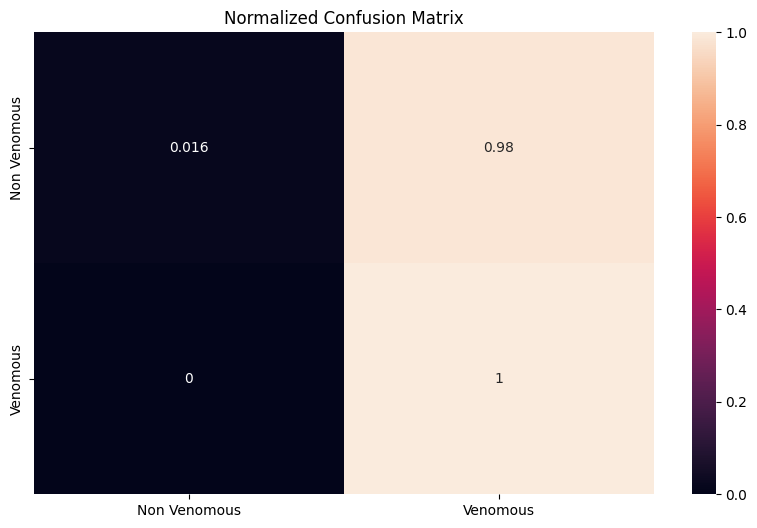

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [41]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=2)
    
    x = base_model(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [54]:
K.clear_session()

In [42]:
model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 16)          184336    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 16)          2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                         

In [47]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
)

Epoch 1/2
176/176 [==============================] - 29s 163ms/step - loss: 0.1139 - accuracy: 0.9694 - val_loss: 0.6873 - val_accuracy: 0.6040
Epoch 2/2
176/176 [==============================] - 29s 164ms/step - loss: 0.0864 - accuracy: 0.9687 - val_loss: 1.0209 - val_accuracy: 0.3989


In [48]:
pd.DataFrame(model.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

ValueError: DataFrame constructor not properly called!

In [49]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.92706
Test Accuracy: 47.94%


In [50]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

34/34 [==============================] - 3s 42ms/step
The first 5 predictions: ['Non Venomous', 'Non Venomous', 'Non Venomous', 'Non Venomous', 'Non Venomous']


In [52]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

Non Venomous       0.48      1.00      0.65       128
    Venomous       0.00      0.00      0.00       139

    accuracy                           0.48       267
   macro avg       0.24      0.50      0.32       267
weighted avg       0.23      0.48      0.31       267



C:\Users\spars\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\spars\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\spars\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

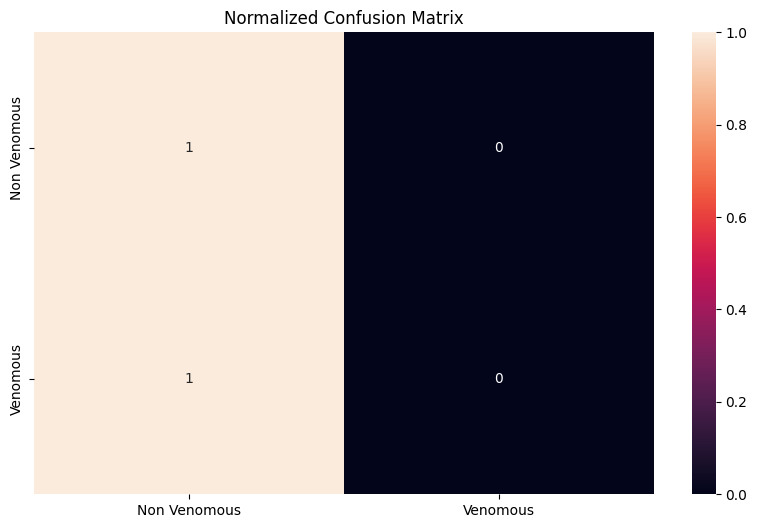

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [71]:
def create_model(input_shape=(224, 224, 3)):
    x = Sequential()
    x.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',input_shape=(224,224,3)))
    x.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    x.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
    x.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    x.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
    x.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    x.add(Dropout(0.2))
    x.add(Flatten())
    x.add(Dense(128, activation='relu'))
    x.add(Dropout(0.2))
    x.add(Dense(2, activation='softmax'))

    return x

In [72]:
model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

In [73]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 111, 111, 16)      2320      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 56, 16)        2320      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 28, 28, 16)      

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2

# Create a Sequential model
model = Sequential()



# Add additional layers on top of MobileNetV2
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Ensure appropriate padding
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Ensure appropriate padding
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Ensure appropriate padding
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Compile the model
history = model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



AttributeError: 'NoneType' object has no attribute 'summary'